Author: **Tewodros W. AREGA** \\
Date: 03-07-2021 \\

Implementation for the paper titled: **Automatic Myocardial Scar Segmentation from
Multi-Sequence Cardiac MRI using Fully
Convolutional Densenet with Inception and
Squeeze-Excitation Module** \\
Link to the paper: http://dx.doi.org/10.1007/978-3-030-65651-5_10

The implementation of Region Mutual Information Loss for Semantic Segmentation (RMI Loss) is taken from: https://github.com/ZJULearning/RMI

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import

In [ ]:
!pip install SimpleITK
!pip install mahotas

#############
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import time
import glob
import sys
import logging
import mahotas
import cv2
from scipy import ndimage


#############
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 42.5MB 73kB/s 
     |████████████████████████████████| 1.5MB 8.8MB/s 
  Created wheel for mahotas: filename=mahotas-1.4.9-cp36-cp36m-linux_x86_64.whl size=4265634 sha256=25b9e29ab0ba41f88d6bf2d901e7daf9a5df7aa5a8acaefe302ff67470348bcc
  Stored in directory: /root/.cache/pip/wheels/02/e7/50/b67eee3b19c479cc5b41f10230bf9c1556be6eaaf095c6e997
Successfully built mahotas


In [ ]:
# Import py files in the folder # If you add new files, you need to mount again

path_folder='Python_Files/'
sys.path.insert(1, path_folder) 

from crfseg import CRF
from rmi import RMILoss
from custom_transforms import RandomHorizFlip, RandomVertFlip, RandomRotate, MyRandomAffine

# Hyper-parameters

In [ ]:
###################################################################
# Hyperparameters
###################################################################
mytime = time.strftime("%Y_%m_%d_%HH_%MM")

options = {}
options['train_split']  = 0.2
# file paths to save the models and results
options["models"]='Model_Results/Models/'
options["results"]='Model_Results/Results/'

class_weights = [1.0, 1.0, 1.0]  
options["loss_type"] = "Hybrid_RMI_loss" 
options["metrics"] = "dicecoeff" 

augment = False
earlystopping = 250
use_model = False
result_save = True

EPOCH_NO = 550
BATCHSIZE = 16
options['batch_size'] = BATCHSIZE

options["optim"] = "adadelta"

lrate = 1e-4    
weightdecay = 1e-7   


wdecay_rmi = 1e-1

wdecay_dice = 1.0

wdecay_cross = 0

#Non-linearity for exponential losses
gamma_dice = 0.3
gamma_cross = 0.3

MODEL_TYPE = "FCDenseNet57_SE_Enc_with_Inception_Add"  


data_name = "MyoPS_MULTI_LVMYOScar_ROI_96" 
exp_name = MODEL_TYPE+'_'+ data_name +'_batchsize_'+str(BATCHSIZE)+'_loss_'+options["loss_type"]+'_optim_'+options["optim"]+'_epoch_'+str(EPOCH_NO)+ '_t'+ mytime

model_name = exp_name

#More comments
comment = "Comment: LVMYOScar " + MODEL_TYPE + " , "+options["loss_type"]+": dice(gamma="+str(gamma_dice)+") RMI_loss="+str(wdecay_rmi) + " bb_loss=" + str(wdecay_bb)

# print(exp_name)
print(comment)

# Custom Dataset

In [ ]:

class Mydataset(data.Dataset):

  def __init__(self, imgs, masks, transform=None, normalize=True):
           
    self.imgs = imgs     
    self.masks = masks
    self.transform = transform
    self.normalize = normalize    

  def __getitem__(self, idx):
    
    #load images ad masks
    img = np.load(self.imgs[idx])
    mask = np.load(self.masks[idx]) 
    
    mask_nm = self.masks[idx]

    #Data Augmentation
    if self.transform is not None:
      sample = {'image':img, 'mask':mask}      
      transformed_sample = self.transform(sample)
      img, mask = transformed_sample['image'], transformed_sample['mask']

    #normalization
    if self.normalize:
      img = normalize_data(img)            

    return img, mask, mask_nm

  def __len__(self):
    return len(self.imgs)

  def load_itk(self, filename):
    """
    Convert the image to a numpy array first 
     and then shuffle the dimensions to get axis in the order z,y,x
    """

    itk_img = sitk.ReadImage(filename)    
    np_img = sitk.GetArrayFromImage(itk_img)

    return itk_img, np_img


def normalize_data(im,
                   norm_type='standard',                   
                   datatype=np.float32):
    """
    Zero mean normalization

    inputs:
    - im: input data
    - norm_type: 'zero_one', 'standard'

    outputs:
    - normalized image
    """    

    if norm_type == 'standard':
        im = im.astype(dtype=datatype) - im[np.nonzero(im)].mean()
        im = im / im[np.nonzero(im)].std()

    if norm_type == 'zero_one':
        min_int = abs(im.min())
        max_int = im.max()
        if im.min() < 0:
            im = im.astype(dtype=datatype) + min_int
            im = im / (max_int + min_int)
        else:
            im = (im.astype(dtype=datatype) - min_int) / max_int
    
    return im


# Load Dataset

In [ ]:
if data_name == "MyoPS_MULTI_LVMYOScar_ROI_96" : 
  resample_dir = 'challenge_Resampled/'
  my_extension = "*_resampled.npy"
  my_mask_extension = "*_resampled_seg.npy"
  image_npy = "Training2020_Images_LVMYOScar_ROI_NPY/" 
  mask_npy = "Training2020_Masks_LVMYOScar_ROI_NPY/"
  image_npy_val = "Validation2020_Images_LVMYOScar_ROI_NPY/" 
  mask_npy_val = "Validation2020_Masks_LVMYOScar_ROI_NPY/"
  image_npy_test = "Test2020_Images_LVMYOScar_ROI_NPY/" 
  mask_npy_test = "Test2020_Masks_LVMYOScar_ROI_NPY/"


img_files = list(sorted( glob.glob(resample_dir +image_npy+ my_extension)  ))      
mask_files = list(sorted( glob.glob(resample_dir +mask_npy+ my_mask_extension) ))

img_files_val = list(sorted( glob.glob(resample_dir +image_npy_val+ my_extension)  ))      
mask_files_val = list(sorted( glob.glob(resample_dir +mask_npy_val+ my_mask_extension) ))

img_files_test = list(sorted( glob.glob(resample_dir +image_npy_test + my_extension)  ))      
mask_files_test = list(sorted( glob.glob(resample_dir +mask_npy_test + my_mask_extension) ))

t_d = int(len(img_files) * (1 - options['train_split']))

training_data = img_files
training_mask = mask_files

validation_data = img_files_val
validation_mask = mask_files_val

test_data = img_files_test
test_mask = mask_files_test

###################################################################
#Applies the same transformation to both image and mask
# Apply augmentation only in training images
###################################################################
mytransform = transforms.Compose([
                                  # RandomHorizFlip(p=0.3),
                                  # RandomVertFlip(p=0.8),
                                  MyRandomAffine(degrees=10, translate=(0.2,0.2), scale=(0.5,2.0)),
                                  RandomRotate(0)                                
                                 ])
if not augment:
  mytransform = None
  
# Dataset:maps each index/key to a data sample
training_dataset = Mydataset(training_data, training_mask, transform=mytransform, normalize=True)
validation_dataset = Mydataset(validation_data, validation_mask, transform=None, normalize=True)
test_dataset = Mydataset(test_data, test_mask, normalize=True)


In [ ]:
print(len(training_data))
print(len(validation_data))
print(len(test_data))

73
11
18


In [ ]:
# Python iterable over a dataset
training_dataloader = DataLoader(training_dataset, 
                                 batch_size=options['batch_size'],
                                 shuffle=True)
validation_dataloader = DataLoader(validation_dataset, 
                                 batch_size=options['batch_size'],
                                 shuffle=True)
test_dataloader = DataLoader(test_dataset, 
                                 batch_size=options['batch_size'],
                                 shuffle=False)

In [ ]:
#check and view images and understand Dataloader and Dataset  
images, labels, nm = next(iter(test_dataloader))
print(labels.shape)
print(images.shape)

torch.Size([16, 1, 96, 96])
torch.Size([16, 3, 96, 96])


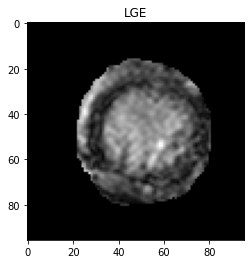

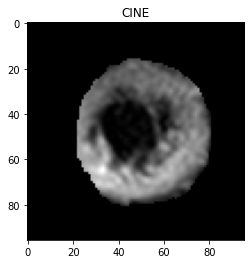

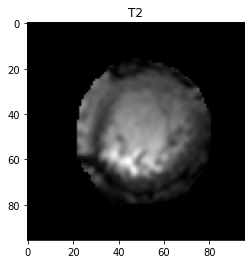

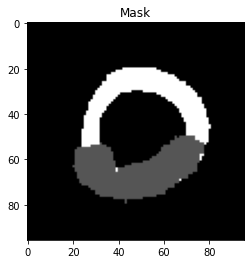

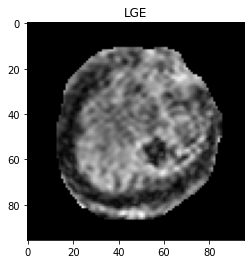

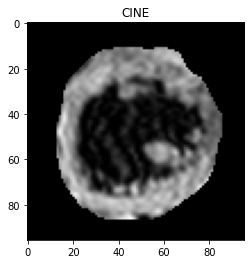

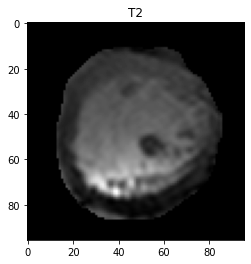

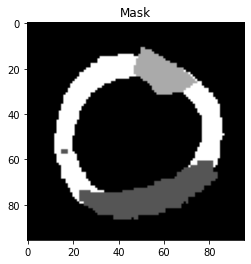

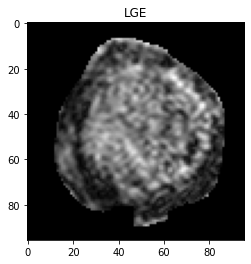

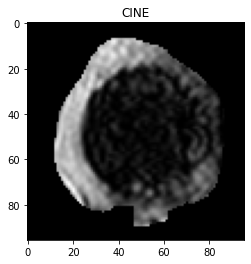

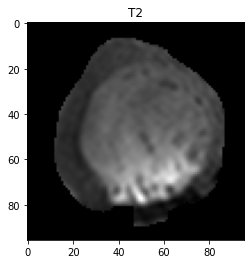

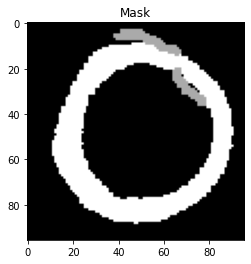

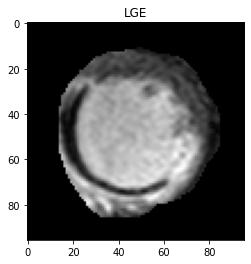

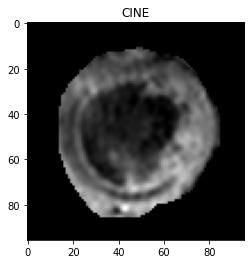

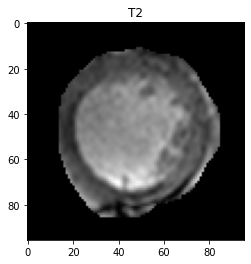

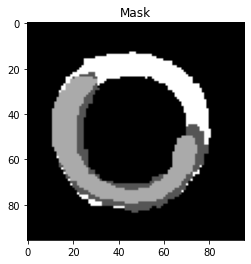

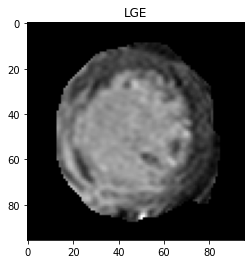

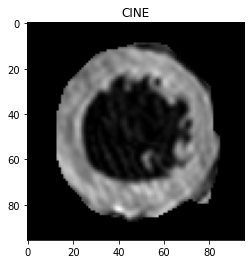

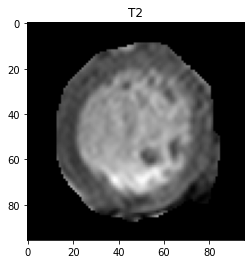

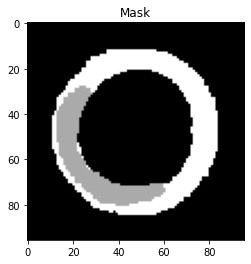

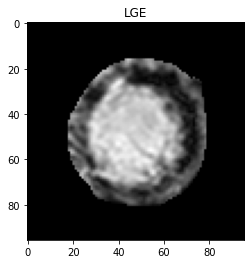

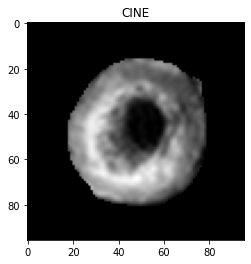

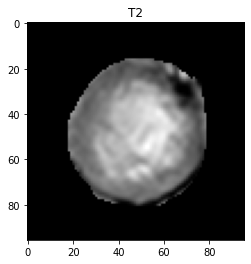

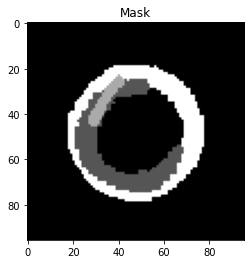

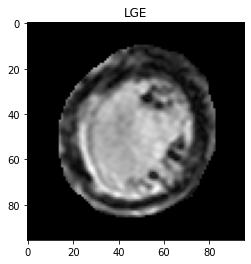

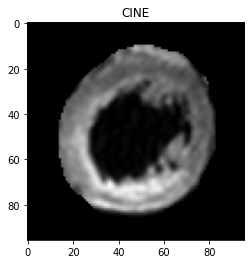

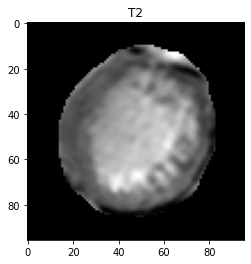

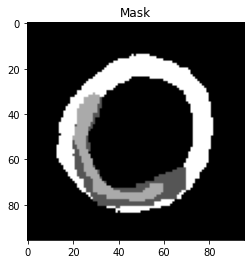

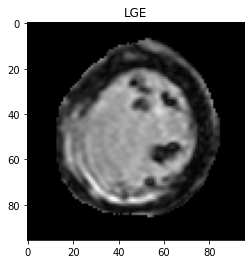

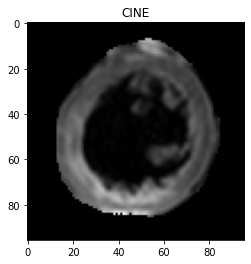

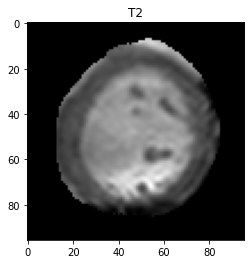

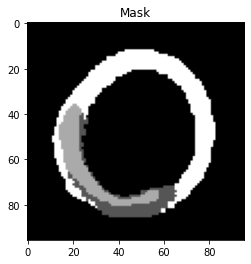

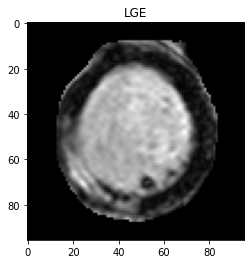

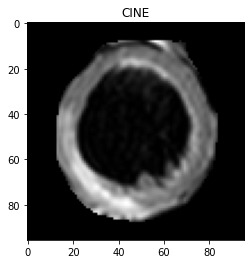

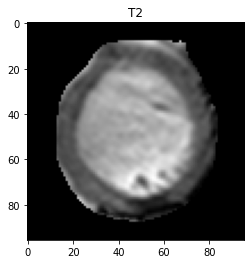

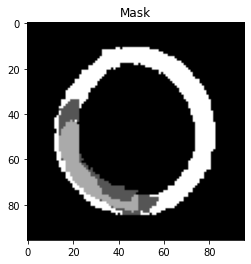

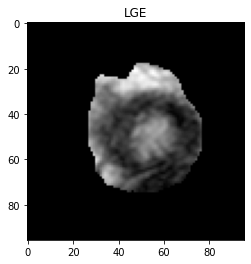

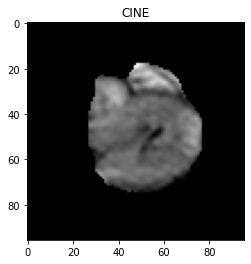

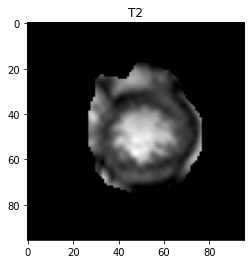

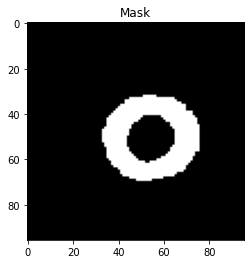

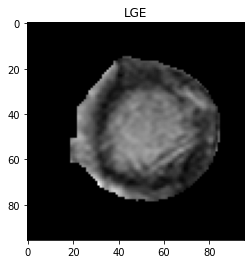

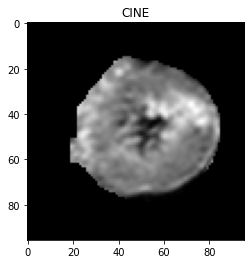

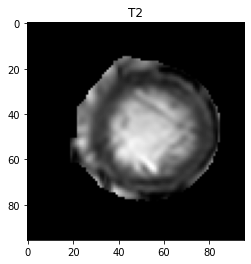

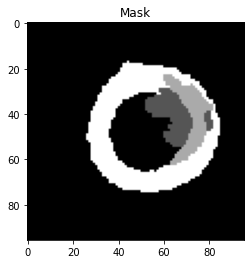

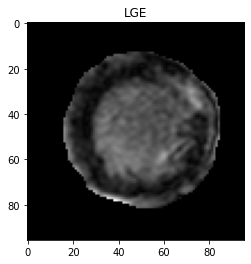

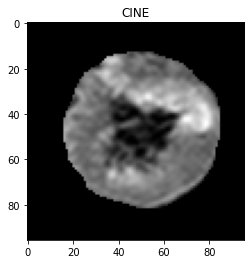

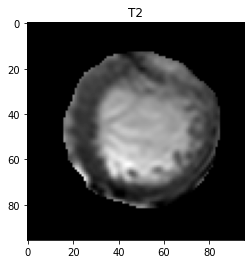

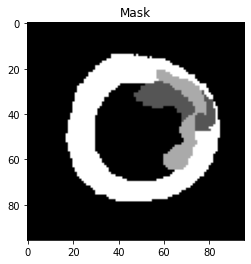

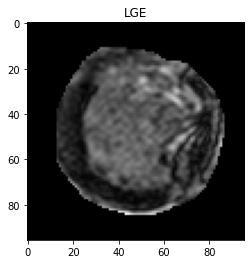

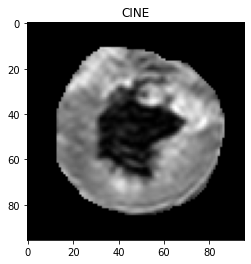

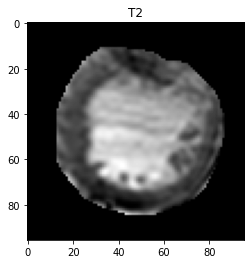

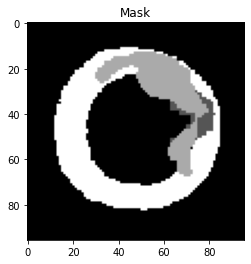

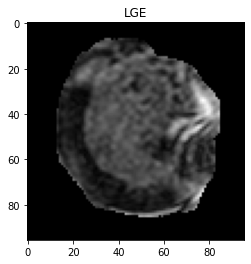

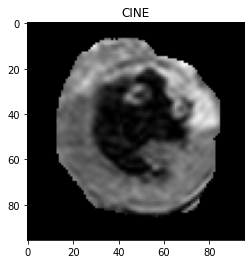

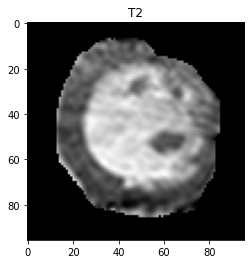

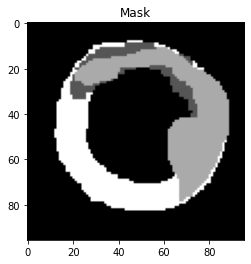

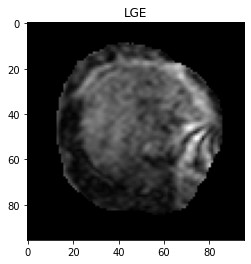

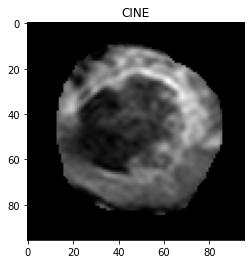

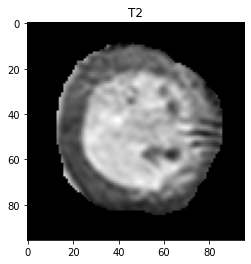

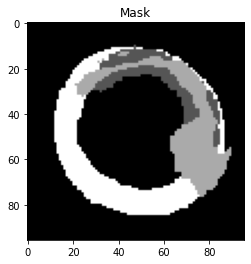

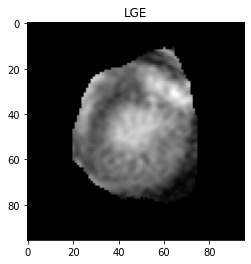

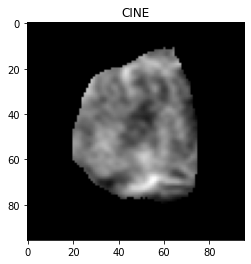

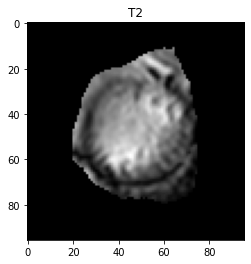

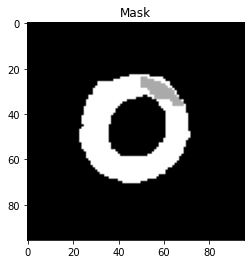

In [ ]:
for j in range(options['batch_size']):
  plt.imshow(images[j,0,:,:], cmap='gray')
  plt.title("LGE")
  plt.show()
  plt.imshow(images[j,1,:,:], cmap='gray')
  plt.title("CINE")
  plt.show()
  plt.imshow(images[j,2,:,:], cmap='gray')
  plt.title("T2")
  plt.show()

  plt.imshow(labels[j,0,:,:], cmap='gray')
  plt.title("Mask")
  plt.show()

#clip very white and black pixels

# Network Architecture

## Simple UNET

In [ ]:
#UNET Architecture

class Unet(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size):

        super(Unet, self).__init__()

        # conv1 down
        self.conv1 = nn.Conv2d(in_channels=input_size,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # max-pool 1
        self.pool1 = nn.Conv2d(in_channels=32,
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # max-pool 2
        self.pool2 = nn.Conv2d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # max-pool 3
        self.pool3 = nn.Conv2d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        # conv4 down (latent space)
        self.conv4 = nn.Conv2d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        # up-sample conv4
        self.up1 = nn.ConvTranspose2d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + conv3)
        self.conv5 = nn.Conv2d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # up-sample conv5
        self.up2 = nn.ConvTranspose2d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2) 
        self.conv6 = nn.Conv2d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # up 3
        self.up3 = nn.ConvTranspose2d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)
        # conv7 (add up3 + conv1)
        self.conv7 = nn.Conv2d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # conv8 (classification)
        self.conv8 = nn.Conv2d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = F.relu(self.conv1(x))
        x1p = self.pool1(x1)
        x2 = F.relu(self.conv2(x1p))
        x2p = self.pool2(x2)
        x3 = F.relu(self.conv3(x2p))
        x3p = self.pool3(x3)
        
        # latent space
        x4 = F.relu(self.conv4(x3p))

        # decoder
        up1 = self.up1(x4)
        x5 = F.relu(self.conv5(up1 + x3)) # look how layers are added :o
        up2 = self.up2(x5)
        x6 = F.relu(self.conv6(up2 + x2))
        up3 = self.up3(x6)
        x7 = F.relu(self.conv7(up3 + x1))
        
        # output layer (2 classes)
        # we use a softmax layer to return probabilities for each class
        out = F.softmax(self.conv8(x7), dim=1) 
        return out


## FCDenseNet

In [ ]:
from dense_layers import *

class FCDenseNet(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5),
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5,
                 growth_rate=16, out_chans_first_conv=48, n_classes=12):
        super().__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks
        cur_channels_count = 0
        skip_connection_channel_counts = []

        ## First Convolution ##

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels,
                  out_channels=out_chans_first_conv, kernel_size=3,
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv

        #####################
        # Downsampling path #
        #####################

        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0, cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))

        #####################
        #     Bottleneck    #
        #####################

        self.add_module('bottleneck',Bottleneck(cur_channels_count,
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels

        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i],
                    upsample=True))
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels

        ## Final DenseBlock ##

        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1],
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]

        ## Softmax ##

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=n_classes, kernel_size=1, stride=1,
                   padding=0, bias=True)
        

    def forward(self, x):
        out = self.firstconv(x)

        skip_connections = []
        for i in range(len(self.down_blocks)):
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)

        out = self.bottleneck(out)
        for i in range(len(self.up_blocks)):
            skip = skip_connections.pop()
            out = self.transUpBlocks[i](out, skip)
            out = self.denseBlocksUp[i](out)

        out = self.finalConv(out)
        out = F.softmax(out, dim=1)
        
        return out


def FCDenseNet57(input_size, output_size):
    return FCDenseNet(
        in_channels=input_size, down_blocks=(4, 4, 4, 4, 4),
        up_blocks=(4, 4, 4, 4, 4), bottleneck_layers=4,
        growth_rate=12, out_chans_first_conv=48, n_classes=output_size)


def FCDenseNet67(n_classes):
    return FCDenseNet(
        in_channels=3, down_blocks=(5, 5, 5, 5, 5),
        up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)


def FCDenseNet103(n_classes):
    return FCDenseNet(
        in_channels=3, down_blocks=(4,5,7,10,12),
        up_blocks=(12,10,7,5,4), bottleneck_layers=15,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

## FCDenseNet with SE Module

In [ ]:
from dense_layers import *

class FCDenseNet_SE(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5),
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5,
                 growth_rate=16, out_chans_first_conv=48, n_classes=12):
        super().__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks

        cur_channels_count = 0       
        skip_connection_channel_counts = []
        skip_channel_counts = []

        ## First Convolution ##

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels,
                  out_channels=out_chans_first_conv, kernel_size=3,
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv

        #####################
        # Downsampling path #
        #####################

        self.denseBlocksDown = nn.ModuleList([])        
        self.transDownBlocks = nn.ModuleList([])

        self.SE_Blocks = nn.ModuleList([])

        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0, cur_channels_count)
            skip_channel_counts.append(cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))

        #####################
        #     Bottleneck    #
        #####################

        self.add_module('bottleneck', Bottleneck(cur_channels_count,
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels
        
        #######################
        #   SE Block   # filters = [16, 32, 64, 128, 256], down_blocks=(4, 4, 4, 4, 4), 5 blocks w/o bottleneck 
        #######################


        for i in range(len(down_blocks)): 
          filter_i = skip_channel_counts[i]
          self.SE_Blocks.append(
                SqEx_Res( n_features=filter_i ) )                         

        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i],
                    upsample=True))
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels

        ## Final DenseBlock ##

        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1],
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]

        ## Softmax ##

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=n_classes, kernel_size=1, stride=1,
                   padding=0, bias=True)
        

    def forward(self, x):
        out = self.firstconv(x)

        skip_connections = []
        skip_connections_after_attn = [] 
        for i in range(len(self.down_blocks)):
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)

        out = self.bottleneck(out)
                       
        # Add SE to the skip connections        
        for i in range(len(self.up_blocks)):
          skip_before = skip_connections[i]
          skip_after = self.SE_Blocks[i](skip_before) 
          skip_connections_after_attn.append(skip_after)

        for i in range(len(self.up_blocks)):
            skip = skip_connections_after_attn.pop()
            out = self.transUpBlocks[i](out, skip)
            out = self.denseBlocksUp[i](out)

        out = self.finalConv(out)
        out = F.softmax(out, dim=1)
        
        return out


def FCDenseNet57_SE(input_size, output_size):
    return FCDenseNet_SE(
        in_channels=input_size, down_blocks=(4, 4, 4, 4, 4),
        up_blocks=(4, 4, 4, 4, 4), bottleneck_layers=4,
        growth_rate=12, out_chans_first_conv=48, n_classes=output_size)


def FCDenseNet67_SE(n_classes):
    return FCDenseNet_SE(
        in_channels=3, down_blocks=(5, 5, 5, 5, 5),
        up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)


def FCDenseNet103_SE(n_classes):
    return FCDenseNet_SE(
        in_channels=3, down_blocks=(4,5,7,10,12),
        up_blocks=(12,10,7,5,4), bottleneck_layers=15,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)
    

# Squeeze-and-Excitation Network, (Inception or Residual) 
class SqEx_Res(nn.Module):

    def __init__(self, n_features, reduction=4):
        super(SqEx_Res, self).__init__()

        if n_features % reduction != 0:
            raise ValueError('n_features must be divisible by reduction (default = 4)')

        self.linear1 = nn.Linear(n_features, n_features // reduction, bias=False)
        self.nonlin1 = nn.ReLU() 
        self.linear2 = nn.Linear(n_features // reduction, n_features, bias=False)
        self.nonlin2 = nn.Sigmoid()

    def forward(self, x):

        residual = x
        y = F.avg_pool2d(x, kernel_size=x.size()[2:4])
        y = y.permute(0, 2, 3, 1) # change [B, C, H,  W] to [1, 1, 1,  C]
        y = self.nonlin1(self.linear1(y))
        y = self.nonlin2(self.linear2(y))
        y = y.permute(0, 3, 1, 2)
        y = x * y

        # y = residual + y

        return y


## FCDenseNet with SE Module/Inception Module -- best

In [ ]:
from dense_layers import *
from ce_net import DACblock, DACblock_with_inception, DACblock_with_inception_blocks, DACblock_without_atrous
#with inception module and element_wise addition instead of concatination
# Adding SE to decoder, 
# Adding Inception styled Dilated Convolution to bottleneck
# Add Inception with addition in the first conv

class FCDenseNet_SE(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5),
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5,
                 growth_rate=16, out_chans_first_conv=48, n_classes=12):
        super().__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks

        cur_channels_count = 0       
        skip_connection_channel_counts = []
        skip_channel_counts = []

        ## First Convolution ##

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels,
                  out_channels=out_chans_first_conv, kernel_size=3,
                  stride=1, padding=1, bias=True))
        
        self.add_module('secondconv', Inception_with_Addition(in_channels, out_chans_first_conv))

        cur_channels_count = out_chans_first_conv
        
         
        #####################
        # Downsampling path #
        #####################

        self.denseBlocksDown = nn.ModuleList([])        
        self.transDownBlocks = nn.ModuleList([])

        self.SE_Blocks = nn.ModuleList([])

        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0, cur_channels_count)
            skip_channel_counts.append(cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))

        #####################
        #     Bottleneck    #
        #####################

        self.add_module('bottleneck', Bottleneck(cur_channels_count,
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels
        
        self.dblock = DACblock(prev_block_channels)

        #######################
        #   SE Block          #  
        #######################


        for i in range(len(down_blocks)): 
          filter_i = skip_channel_counts[i]
          self.SE_Blocks.append(
                SqEx_Res( n_features=filter_i ) )                         

        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i],
                    upsample=True))            
            
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels
            

        ## Final DenseBlock ##

        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1],
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]

        ## Softmax ##

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=n_classes, kernel_size=1, stride=1,
                   padding=0, bias=True)
        

    def forward(self, x):
        # out = self.firstconv(x)

        out = self.secondconv(x)

        #Downsample
        skip_connections = []
        skip_connections_after_attn = [] 
        for i in range(len(self.down_blocks)):
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)
        
        #Bottleneck
        out = self.bottleneck(out)
        # Dilated Convolution 
        # out = self.dblock(out)

        #Add SE to the skip connections        
        for i in range(len(self.up_blocks)):
          skip_before = skip_connections[i]
          skip_after = self.SE_Blocks[i](skip_before) 
          skip_connections_after_attn.append(skip_after)
        
        #Upsample
        for i in range(len(self.up_blocks)):
            skip = skip_connections_after_attn.pop()
            out = self.transUpBlocks[i](out, skip)
            out = self.denseBlocksUp[i](out)            
        
        out = self.finalConv(out)
        out = F.softmax(out, dim=1)
        
        return out


def FCDenseNet57_SE_Enc_with_Inception_Add(input_size, output_size):
    return FCDenseNet_SE(
        in_channels=input_size, down_blocks=(4, 4, 4, 4, 4),
        up_blocks=(4, 4, 4, 4, 4), bottleneck_layers=4,
        growth_rate=12, out_chans_first_conv=48, n_classes=output_size)


def FCDenseNet67_SE(n_classes):
    return FCDenseNet_SE(
        in_channels=3, down_blocks=(5, 5, 5, 5, 5),
        up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)


def FCDenseNet103_SE(n_classes):
    return FCDenseNet_SE(
        in_channels=3, down_blocks=(4,5,7,10,12),
        up_blocks=(12,10,7,5,4), bottleneck_layers=15,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)
    

# Utils

In [ ]:
def plotMetrics(training_acc, val_acc, training_loss, val_loss):        
    current_time = time.time()    
    # training and val accuracy
    epoch_list = tuple(range(0,len(training_acc),1))
    plt.plot(training_acc)
    plt.plot(val_acc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    acc_path = options["results"] + "Plot/accuracy_"+exp_name+".png"
    plt.savefig(acc_path)   
    plt.show()

    # training and val loss
    plt.plot(training_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    loss_path = options["results"] + "Plot/loss_"+exp_name+".png"
    plt.savefig(loss_path)   
    plt.show()


# Loss Functions and Metrics

In [ ]:
def dice_coef_metric(pred, target):
  """This definition generalize to real valued pred and target vector.
      This should be differentiable.
      pred: tensor with first dimension as batch
      target: tensor with first dimension as batch
  """
  smooth = 1.
  iflat = pred.contiguous().view(-1)
  tflat = target.contiguous().view(-1)
  intersection = (iflat * tflat).sum()
  A_sum = torch.sum(iflat * iflat)
  B_sum = torch.sum(tflat * tflat)
  dice_score = ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
  
  return dice_score.cpu().detach().numpy()  

#dice is 1 if there is no scar and edema in both GT and predicted images
def dice_coef_metric_scar(pred, target):
  """This definition generalize to real valued pred and target vector.
      This should be differentiable.
      pred: tensor with first dimension as batch
      target: tensor with first dimension as batch
  """
  smooth = 1.
  iflat = pred.contiguous().view(-1)
  tflat = target.contiguous().view(-1)
  intersection = (iflat * tflat).sum()
  if intersection == 0:
    return 1.0
  A_sum = torch.sum(iflat * iflat)
  B_sum = torch.sum(tflat * tflat)
  dice_score = ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
  
  return dice_score.cpu().detach().numpy()  

def dice_loss(pred, target):
  """This definition generalize to real valued pred and target vector.
      This should be differentiable.
      pred: tensor with first dimension as batch
      target: tensor with first dimension as batch
  """
  smooth = 1.
  iflat = pred.contiguous().view(-1)
  tflat = target.contiguous().view(-1)
  intersection = (iflat * tflat).sum()
  A_sum = torch.sum(iflat * iflat)
  B_sum = torch.sum(tflat * tflat)
  
  return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) ) 

def dice_loss_all(pred, target, weight=None):
   
  if weight == None:
    weight = [1.0, 1.0, 1.0]
  
  loss_backgr = dice_loss(pred[:,0,:,:], target[:,0,:,:])
  loss_edema = dice_loss(pred[:,1,:,:], target[:,1,:,:])
  loss_scar = dice_loss(pred[:,2,:,:], target[:,2,:,:])
  loss_normal_myo = dice_loss(pred[:,3,:,:], target[:,2,:,:])

  #average loss
  avg_loss = (weight[0] * loss_edema  + weight[1] * loss_scar + weight[2] * loss_normal_myo) / 3
  
  return avg_loss

def dice_loss_exponential(pred, target, weight=None, gamma = 0.3):  
  
  loss_backgr = torch.pow(-1 * torch.log( 1 - dice_loss(pred[:,0,:,:], target[:,0,:,:]) ), gamma)
  loss_edema = torch.pow(-1 * torch.log( 1 - dice_loss(pred[:,1,:,:], target[:,1,:,:]) ),  gamma)
  loss_scar = torch.pow(-1 * torch.log( 1 - dice_loss(pred[:,2,:,:], target[:,2,:,:]) ),  gamma)
  loss_normal_myo = torch.pow(-1 * torch.log( 1 - dice_loss(pred[:,3,:,:], target[:,3,:,:]) ),  gamma)

  #average loss
  avg_loss = (loss_edema  + loss_scar + loss_normal_myo) / 3
  
  return avg_loss

def largest_connected(img_temp):

  img_temp = img_temp.cpu().numpy()
  temp = img_temp.squeeze() 

  image = temp
  image = image.astype('uint8')
  large_comps = np.zeros_like(image)  

  nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image[:,:], connectivity=4)
  area_sizes = stats[:, -1]        

  max_label = 1
  max_size = area_sizes[1]
  for i in range(2, nb_components):
      if area_sizes[i] > max_size:
          max_label = i
          max_size = area_sizes[i]

  img2 = np.zeros(output.shape)
  img2[output == max_label] = 1
  large_comps = img2
  large_comps = np.expand_dims(large_comps, axis=0)

  return large_comps

# Post Processing

In [ ]:
def post_processing_scar():
  
  #morphological operations [opening, closing, top-hat...]

 return  

def post_processing_image(pred_image):

  pred_img_lv = (pred_image > 1) * 1  
  pred_img_myo = (pred_image >= 1) * 1

  connected_pred_lv = largest_connected(pred_img_lv) 
  connected_pred_myo = largest_connected(pred_img_myo) 

  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
  kernel2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (11,11))
  kernel3 = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

  closed_pred_lv = cv2.morphologyEx(connected_pred_lv[0,:,:], cv2.MORPH_CLOSE, kernel)
  opened_pred_lv = cv2.morphologyEx(closed_pred_lv, cv2.MORPH_OPEN, kernel3)

  closed_pred_myo = cv2.morphologyEx(connected_pred_myo[0,:,:], cv2.MORPH_CLOSE, kernel)
  opened_pred_myo = cv2.morphologyEx(closed_pred_myo, cv2.MORPH_OPEN, kernel2)

  myo_result = opened_pred_myo - opened_pred_lv
  final_result = myo_result + (opened_pred_lv * 2)

  final_result = np.expand_dims(final_result, axis=(0,1))
  final_result = torch.tensor(final_result)
  final_result = final_result.to(device)

  return final_result

# Logger

In [ ]:
# -----------------------------
# Set the logger 
# -----------------------------
logger = logging.getLogger()
fh = logging.FileHandler("{}/{}/{}".format(options["results"],"Logger",exp_name))
sh = logging.StreamHandler(sys.stdout)
logger.addHandler(fh)
logger.addHandler(sh)
logger.setLevel(logging.INFO)
logger.info("Logging initiated")


Logging initiated


# Training for 4 Classes

In [ ]:
import copy
# import segmentation_models_pytorch as smp
INPUT_SIZE = 3
OUTPUT_SIZE = 4
hybrid_loss_name = "Hybrid_RMI_loss"
##################################################
# Save Remarks 
##################################################
file_comment = open(r"Model_Results/Results/Plot/remarks_"+exp_name+".txt","w") 
file_comment.writelines(comment) 
file_comment.close() #to change file access modes 

logger.info(comment)
##################################################
##################################################

In [ ]:

# mkdir for stored models
if not os.path.isdir(options["models"]):
        os.makedirs(options["models"])

# some training options
options['gpu_use'] = True
options['num_epochs'] = EPOCH_NO

# define the torch.device
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')

# Define the Unet model 
if MODEL_TYPE == "unet":
  segmentation_model = Unet(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE)
elif MODEL_TYPE == "FCDensenet57": 
  segmentation_model = FCDenseNet57(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE)
elif MODEL_TYPE == "FCDenseNet57_SE_Enc_with_Inception_Add": 
  segmentation_model = FCDenseNet57_SE_Enc_with_Inception_Add(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE)

#Region Mutual Information
rmi_criterion = RMILoss(num_classes=OUTPUT_SIZE)

# define the optimizer
if options["optim"] == "sgd":
  optimizer = optim.SGD(segmentation_model.parameters(), lr=lrate, momentum=0.9, weight_decay=weightdecay)
elif options["optim"] == "adadelta":  
  optimizer = optim.Adadelta(segmentation_model.parameters())
elif options["optim"] == "adam":  
  optimizer = optim.Adam(segmentation_model.parameters(), lr=lrate, weight_decay=weightdecay) #weight_decay, lambda, L2 regularization
else:
  print("Please choose correct optimizer")

logger.info("Exp-Name:"+exp_name)

segmentation_model = segmentation_model.to(device)

#
best_model_wts = copy.deepcopy(segmentation_model.state_dict())

training_loss_list = []
training_acc_list = []
val_loss_list = []
val_acc_list = []
best_loss = 1e+5

# training loop
early_count = 0
since = time.time()
training = True
epoch = 1
try:
    while training:
    
        # epoch specific metrics
        train_loss = 0
        
        train_accuracy = 0
        dice_endocard = 0
        dice_myo = 0
        dice_normal_myo = 0
        dice_backgr = 0
        
        
        val_loss = 0
        
        val_accuracy = 0
        dice_endocard_val = 0
        dice_myo_val = 0
        dice_normal_myo_val = 0
        dice_backgr_val = 0        
        
        # -----------------------------
        # training samples
        # -----------------------------
        
        # set the model into train mode
        segmentation_model.train() # the dropout will take affect because it is useful only in training part
        for b_training, batch in enumerate(training_dataloader):
    
                x = batch[0].to(device)
                y = batch[1].to(device)

                # clear gradients
                optimizer.zero_grad()
                
                
                pred = segmentation_model(x)
                pred_prob = pred
                
                # compute the loss.                      
                if options["loss_type"] == "diceloss":
                  #One hot encoded label
                  y_sq = y.squeeze(dim=1).long() # N, d2, d3
                  target = F.one_hot(y_sq, num_classes = OUTPUT_SIZE).permute(0,3,1,2).contiguous()  #N, C, d1, d2                
                  loss = dice_loss_all(pred, target) 
                
                elif options["loss_type"] == "crossentropy": 
                  
                  
                  loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),   
                                      y.squeeze(dim=1).long()) #

                elif options["loss_type"] == "RMI_loss": 
                                  
                  loss = rmi_criterion(torch.clamp(pred, 1E-7, 1.0), y.squeeze(dim=1).long())
                
                elif options["loss_type"] == hybrid_loss_name:

                  cross_loss_ = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),   
                                       y.squeeze(dim=1).long(), reduction='none') 
                  

                  # Exponential Dice Loss
                  y_sq = y.squeeze(dim=1).long() # N, d2, d3
                  target = F.one_hot(y_sq, num_classes = OUTPUT_SIZE).permute(0,3,1,2).contiguous()  #N, C, d1, d2                
                  loss_dice = dice_loss_exponential(pred, target, gamma = gamma_dice)

                  #Structural Similarity Loss
                  rmi_loss = rmi_criterion(torch.clamp(pred, 1E-7, 1.0), y.squeeze(dim=1).long())
                  

                  loss =  loss_dice * wdecay_dice  + rmi_loss * wdecay_rmi  
                  

                else:
                      print("Please Choose the correct Loss type")
                      training = False
                      break
                               
                train_loss += loss.item()
                                
                # calculates the gradient wrt the loss 
                loss.backward()
                #update the weights based on the computed gradient
                optimizer.step()
                
                if options["metrics"] == "accuracy":
                  # compute the accuracy
                  pred = pred.max(1, keepdim=True)[1]
                  batch_accuracy = pred.eq(y.view_as(pred).long())
                  train_accuracy += (batch_accuracy.sum().item() / np.prod(y.shape))   

                elif options["metrics"] == "dicecoeff":
                  y_sq = y.squeeze(dim=1).long() # N, d2, d3
                  target = F.one_hot(y_sq, num_classes = OUTPUT_SIZE).permute(0,3,1,2).contiguous()  #N, C, d1, d2                
                  #Argmax
                  pred = pred.max(1, keepdim=True)[1]
                  
                  dice_backgr += dice_coef_metric(pred_prob[:,0,:,:], target[:,0,:,:])
                  dice_myo += dice_coef_metric(pred_prob[:,1,:,:], target[:,1,:,:])
                  dice_endocard += dice_coef_metric(pred_prob[:,2,:,:], target[:,2,:,:])
                  dice_normal_myo += dice_coef_metric(pred_prob[:,3,:,:], target[:,3,:,:])
                  
                  
                  
                
        # -----------------------------
        # validation samples
        # -----------------------------
    
        # set the model into validation mode
        segmentation_model.eval()
        for b_validation, batch in enumerate(validation_dataloader):
                x = batch[0].to(device)
                y = batch[1].to(device)
                # infer the current batch 
                with torch.no_grad():
                    pred = segmentation_model(x)
                    pred_prob = pred                    
                    

                    # Compute the loss 
                    if options["loss_type"] == "diceloss":
                      
                      
                      y_sq = y.squeeze(dim=1).long() # N, d2, d3
                      target = F.one_hot(y_sq, num_classes = OUTPUT_SIZE).permute(0,3,1,2).contiguous()  #N, C, d1, d2                   
                      loss = dice_loss_all(pred, target)
                    elif options["loss_type"] == "crossentropy":
                      loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),   #log of softmax prediction (in range 1E-7, 1.0) 
                                          y.squeeze(dim=1).long()) #

                    elif options["loss_type"] == "RMI_loss": 
                                                        
                      loss = rmi_criterion(torch.clamp(pred, 1E-7, 1.0), y.squeeze(dim=1).long())
                   
                    
                    elif options["loss_type"] == hybrid_loss_name:
                  
                      
                      cross_loss_ = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),   
                                       y.squeeze(dim=1).long(), reduction='none') 
                  
                      # Boundary Loss
                      cross_loss_ = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),   
                                          y.squeeze(dim=1).long(), reduction='none')
                     
                      # Exponential Dice Loss
                      y_sq = y.squeeze(dim=1).long() # N, d2, d3
                      target = F.one_hot(y_sq, num_classes = OUTPUT_SIZE).permute(0,3,1,2).contiguous()  #N, C, d1, d2                
                      loss_dice = dice_loss_exponential(pred, target, gamma = gamma_dice)

                      #Structral Similarity Loss
                      rmi_loss = rmi_criterion(torch.clamp(pred, 1E-7, 1.0), y.squeeze(dim=1).long())

                      loss =  loss_dice * wdecay_dice  + rmi_loss * wdecay_rmi 

                    else:
                      print("Please Choose the correct Loss type")
                      training = False
                      break
                                        
                  
                    val_loss += loss.item()

                    if options["metrics"] == "accuracy":
                      # Compute the accuracy                     
                      pred = pred.max(1, keepdim=True)[1]
                      batch_accuracy = pred.eq(y.view_as(pred).long())
                      val_accuracy += batch_accuracy.sum().item() / np.prod(y.shape)   

                    elif options["metrics"] == "dicecoeff":
                      y_sq = y.squeeze(dim=1).long() # N, d2, d3
                      target = F.one_hot(y_sq, num_classes = OUTPUT_SIZE).permute(0,3,1,2).contiguous()  #N, C, d1, d2                   
                      # Argmax: returns (values, indices)
                      pred = pred.max(1, keepdim=True)[1]

                      dice_backgr_val += dice_coef_metric(pred_prob[:,0,:,:], target[:,0,:,:])
                      dice_myo_val += dice_coef_metric(pred_prob[:,1,:,:], target[:,1,:,:])
                      dice_endocard_val += dice_coef_metric(pred_prob[:,2,:,:], target[:,2,:,:])        
                      dice_normal_myo_val += dice_coef_metric(pred_prob[:,3,:,:], target[:,3,:,:])                             
                                       
        
        # compute mean metrics, the average of total batch dices
        train_loss /= (b_training + 1)
        train_accuracy /= (b_training + 1)
        dice_myo /= (b_training + 1)
        dice_endocard /= (b_training + 1)
        dice_normal_myo /= (b_training + 1)
        dice_backgr /= (b_training + 1)
        dice_avg = (dice_endocard + dice_myo + dice_backgr) / 3
        
        val_loss /= (b_validation + 1)
        val_accuracy /= (b_validation + 1)
        dice_endocard_val /= (b_validation + 1)
        dice_myo_val /= (b_validation + 1)
        dice_normal_myo_val /= (b_validation + 1)
        dice_backgr_val /= (b_validation + 1)
        dice_avg_val = (dice_endocard_val + dice_myo_val + dice_backgr_val) / 3

        # Save the training and val acc + loss for each batch
        
        training_acc_list.append(train_accuracy) if options["metrics"] == "accuracy" else  training_acc_list.append(dice_avg)
        training_loss_list.append(train_loss)
        val_acc_list.append(val_accuracy) if options["metrics"] == "accuracy" else   val_acc_list.append(dice_avg_val)
        val_loss_list.append(val_loss)

        if options["metrics"] == "accuracy": 
          logger.info('Epoch {:d}/{:d} train_loss {:.4f} train_acc {:.4f} val_loss {:.4f} val_acc {:.4f}'.format(
              epoch, 
              EPOCH_NO,
              train_loss, 
              train_accuracy,
              val_loss,
              val_accuracy))
        elif options["metrics"] == "dicecoeff":
          logger.info('Epoch {:d}/{:d} diceloss {:.4f} dice_scar {:.4f} dice_edema {:.4f} dice_myo {:.4f} dice_backgr {:.4f} val_diceloss {:.4f} val_dice_scar {:.4f} val_dice_edema {:.4f} val_dice_myo {:.4f} val_dice_backgr {:.4f} '.format(
              epoch, 
              EPOCH_NO,
              train_loss, 
              dice_endocard, 
              dice_myo, 
              dice_normal_myo,
              dice_backgr,              
              val_loss,
              dice_endocard_val, 
              dice_myo_val, 
              dice_normal_myo_val,
              dice_backgr_val))
       
        # update epochs
        epoch += 1
 
        #Save weights if loss decreases
        if val_loss < best_loss:          
          best_loss = val_loss
          early_count = 0
          logger.info("val loss decreased...saving model")          
          best_model_wts = copy.deepcopy(segmentation_model.state_dict()) 
          torch.save(segmentation_model.state_dict(), 
                  os.path.join(options['models'], model_name +'.pt'))          
        elif val_loss > best_loss:
              early_count += 1

        if epoch >= options['num_epochs'] or early_count == earlystopping:
            training = False
            if early_count == earlystopping:
              print("Early stopping")
            time_elapsed = time.time() - since
            logger.info('Training complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
            # load best model weights
            segmentation_model.load_state_dict(best_model_wts) #
            plotMetrics(training_acc_list, val_acc_list, training_loss_list, val_loss_list)
        
except KeyboardInterrupt:
    pass
                        

# Inference

## Validation

In [ ]:
from scipy.spatial.distance import directed_hausdorff

metrics = np.zeros((len(validation_data), 6))



validation_dataloader_one = DataLoader(validation_dataset, 
                                 batch_size=1,
                                 shuffle=False)


# set the model into validation mode
segmentation_model.eval()
for ii, batch in enumerate(validation_dataloader_one):
  x = batch[0].to(device)
  y = batch[1].to(device)
  # infer the current batch 
  with torch.no_grad():
      pred = segmentation_model(x)
      pred_prob = pred
            
      y_sq = y.squeeze(dim=1).long() # N, d2, d3
      target = F.one_hot(y_sq, num_classes = OUTPUT_SIZE).permute(0,3,1,2).contiguous()  #N, C, d1, d2                   
      # Argmax: returns (values, indices)
      pred = pred.max(1, keepdim=True)[1]
      
      dice_myo_test = dice_coef_metric_scar(pred_prob[:,1,:,:], target[:,1,:,:])
      dice_endocard_test = dice_coef_metric_scar(pred_prob[:,2,:,:], target[:,2,:,:])
      dice_normal_myo_test = dice_coef_metric_scar(pred_prob[:,3,:,:], target[:,3,:,:])

      hd_myo_test = directed_hausdorff(pred_prob[0,1,:,:].cpu().numpy(), target[0,1,:,:].cpu().numpy())[0]
      hd_endocard_test = directed_hausdorff(pred_prob[0,2,:,:].cpu().numpy(), target[0,2,:,:].cpu().numpy())[0] 
      hd_normal_myo_test = directed_hausdorff(pred_prob[0,3,:,:].cpu().numpy(), target[0,3,:,:].cpu().numpy())[0]
      
      metrics[ii, 0], metrics[ii, 1], metrics[ii, 2] = dice_endocard_test, dice_myo_test, dice_normal_myo_test
      metrics[ii, 3], metrics[ii, 4], metrics[ii, 5] = hd_endocard_test, hd_myo_test, hd_normal_myo_test

      print("Scar: {:.4f} Edema: {:.4f} N_MYO: {:.4f} HD-Scar: {:.4f} HD-Edema: {:.4f} HD-N_Myo: {:.4f} ".format(metrics[ii,0], metrics[ii,1], metrics[ii,2], metrics[ii,3], metrics[ii,4], metrics[ii,5]))
      #Display the result of a batch      
      fig=plt.figure(figsize=(8, 8))
      fig.add_subplot(1, 3, 1)
      plt.imshow(batch[0][0,0,:,:],cmap='gray')      
      plt.title("Image")
      fig.add_subplot(1,3, 2)
      pred_cpu=pred.cpu().numpy()
      plt.imshow(pred_cpu[0,0,:,:])       
      plt.title("Predicted")
      fig.add_subplot(1, 3, 3)
      plt.imshow(batch[1][0,0,:,:])
      plt.title("GT")
      plt.show()                    

        
# we use PANDAS to describe data :)
import pandas as pd

df_evaluation = pd.DataFrame(metrics, columns=['Scar', 'Edema', 'N_MYO',  'Hausdorff Scar', 'Hausdorff Edema', 'Hausdorff N_MYO']) 

if result_save:
  df_evaluation.describe().T.to_excel(options["results"]+"Plot/validation_"+exp_name+".xlsx")
df_evaluation.describe().T


## Test

Scar: 1.0000 Edema: 0.1769 N_MYO: 0.6412 HD-Scar: 0.0955 HD-Edema: 1.5856 HD-N_Myo: 2.5405 


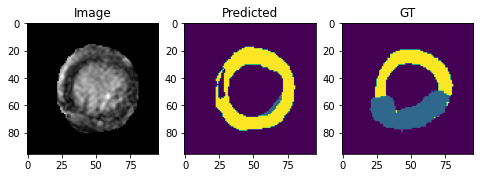

Scar: 0.6481 Edema: 0.0782 N_MYO: 0.6529 HD-Scar: 2.8249 HD-Edema: 1.6556 HD-N_Myo: 4.7980 


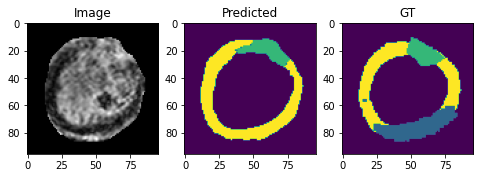

Scar: 0.1229 Edema: 1.0000 N_MYO: 0.7825 HD-Scar: 1.9622 HD-Edema: 1.8419 HD-N_Myo: 3.6566 


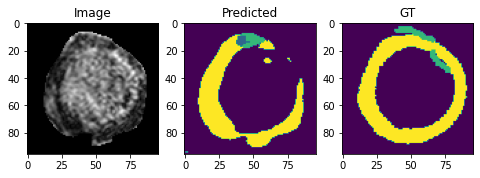

Scar: 0.4904 Edema: 0.1233 N_MYO: 0.6947 HD-Scar: 3.5731 HD-Edema: 1.2929 HD-N_Myo: 3.6147 


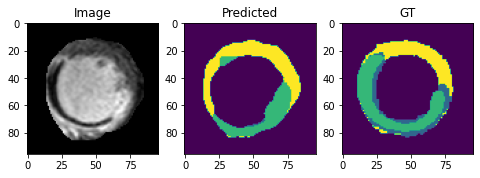

Scar: 0.6679 Edema: 1.0000 N_MYO: 0.7214 HD-Scar: 3.0896 HD-Edema: 1.3844 HD-N_Myo: 3.6630 


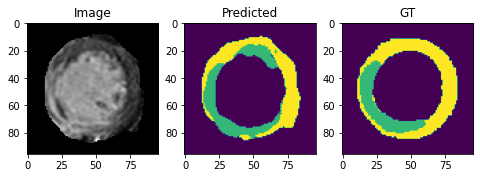

Scar: 0.5034 Edema: 0.6694 N_MYO: 0.8358 HD-Scar: 1.2929 HD-Edema: 2.5724 HD-N_Myo: 2.5784 


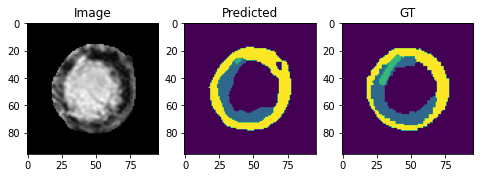

Scar: 0.6543 Edema: 0.5716 N_MYO: 0.8664 HD-Scar: 2.3348 HD-Edema: 2.9833 HD-N_Myo: 3.3047 


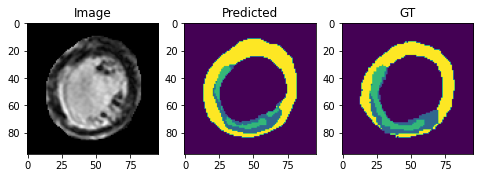

Scar: 0.6122 Edema: 0.4218 N_MYO: 0.8729 HD-Scar: 2.1053 HD-Edema: 2.7849 HD-N_Myo: 3.1452 


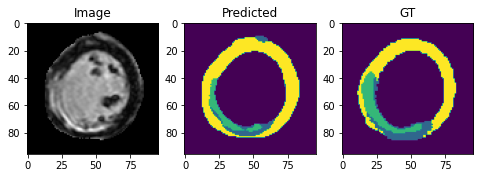

Scar: 0.5067 Edema: 0.3186 N_MYO: 0.8364 HD-Scar: 1.6418 HD-Edema: 2.2104 HD-N_Myo: 3.0655 


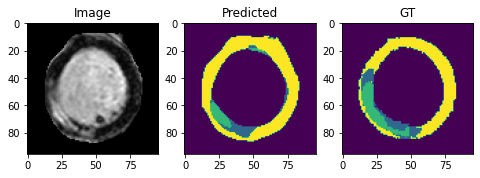

Scar: 1.0000 Edema: 1.0000 N_MYO: 0.8057 HD-Scar: 3.5306 HD-Edema: 1.0139 HD-N_Myo: 2.9539 


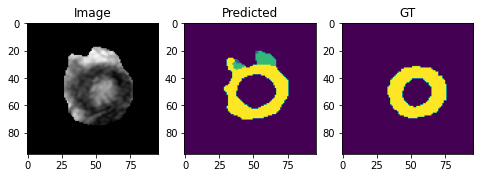

Scar: 0.3933 Edema: 0.3472 N_MYO: 0.8418 HD-Scar: 1.5724 HD-Edema: 2.4337 HD-N_Myo: 2.8684 


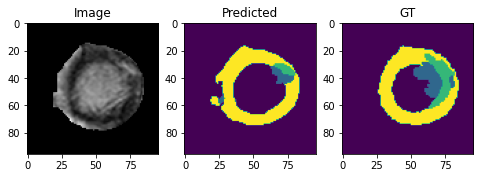

Scar: 0.4211 Edema: 0.7090 N_MYO: 0.9236 HD-Scar: 2.3492 HD-Edema: 2.3299 HD-N_Myo: 3.0128 


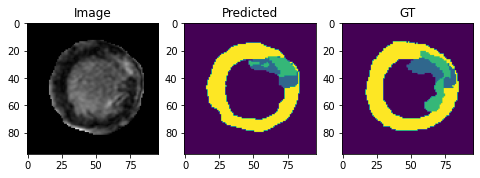

Scar: 0.7555 Edema: 0.4664 N_MYO: 0.8770 HD-Scar: 2.5115 HD-Edema: 1.8454 HD-N_Myo: 2.8125 


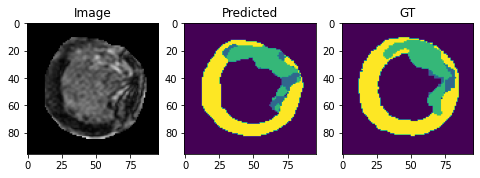

Scar: 0.6494 Edema: 0.3015 N_MYO: 0.8354 HD-Scar: 3.7284 HD-Edema: 1.5729 HD-N_Myo: 2.8619 


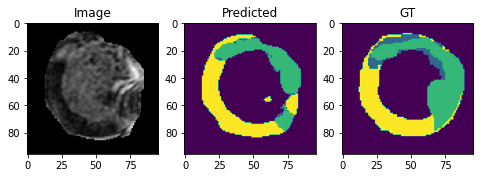

Scar: 0.6966 Edema: 0.3043 N_MYO: 0.8136 HD-Scar: 3.7151 HD-Edema: 2.0160 HD-N_Myo: 2.9541 


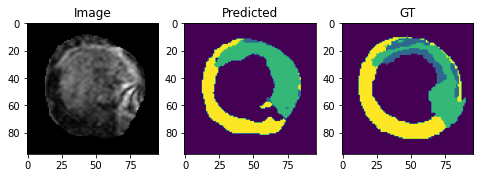

Scar: 0.1575 Edema: 1.0000 N_MYO: 0.3886 HD-Scar: 1.8056 HD-Edema: 0.4612 HD-N_Myo: 3.5533 


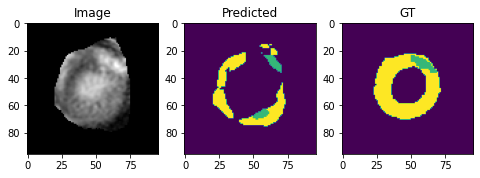

Scar: 0.6747 Edema: 0.1561 N_MYO: 0.6578 HD-Scar: 3.7694 HD-Edema: 0.8032 HD-N_Myo: 3.7784 


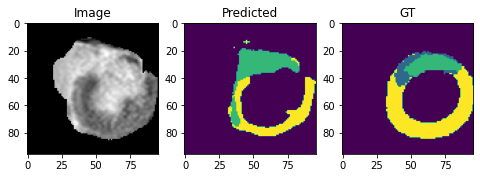

Scar: 0.7120 Edema: 0.2790 N_MYO: 0.5338 HD-Scar: 2.8433 HD-Edema: 0.8160 HD-N_Myo: 3.6007 


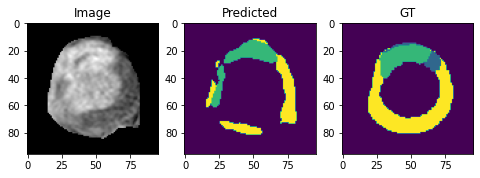

,count,mean,std,min,25%,50%,75%,max
Scar,18.0,0.592552,0.231537,0.122888,0.493682,0.648720,0.691135,1.000000
Edema,18.0,0.495751,0.326269,0.078184,0.284612,0.384533,0.699110,1.000000
N_MYO,18.0,0.754528,0.138110,0.388624,0.667031,0.809643,0.840413,0.923619
Hausdorff Scar,18.0,2.485862,1.005605,0.095463,1.844727,2.430373,3.420337,3.769350
Hausdorff Edema,18.0,1.755762,0.717566,0.461151,1.315781,1.748730,2.300067,2.983335
Hausdorff N_MYO,18.0,3.264595,0.546500,2.540467,2.889748,3.105387,3.611219,4.798019


In [ ]:
from scipy.spatial.distance import directed_hausdorff

metrics = np.zeros((len(test_data), 6))


test_dataloader_one = DataLoader(test_dataset, 
                                 batch_size=1,
                                 shuffle=False)


# set the model into validation mode
segmentation_model.eval()
for ii, batch in enumerate(test_dataloader_one):
  x = batch[0].to(device)
  y = batch[1].to(device)
  # infer the current batch 
  with torch.no_grad():
      pred = segmentation_model(x)
      pred_prob = pred
            
      y_sq = y.squeeze(dim=1).long() # N, d2, d3
      target = F.one_hot(y_sq, num_classes = OUTPUT_SIZE).permute(0,3,1,2).contiguous()  #N, C, d1, d2                   
      # Argmax: returns (values, indices)
      pred = pred.max(1, keepdim=True)[1]
      
      dice_myo_test = dice_coef_metric_scar(pred_prob[:,1,:,:], target[:,1,:,:])
      dice_endocard_test = dice_coef_metric_scar(pred_prob[:,2,:,:], target[:,2,:,:])
      dice_normal_myo_test = dice_coef_metric_scar(pred_prob[:,3,:,:], target[:,3,:,:])

      hd_myo_test = directed_hausdorff(pred_prob[0,1,:,:].cpu().numpy(), target[0,1,:,:].cpu().numpy())[0]
      hd_endocard_test = directed_hausdorff(pred_prob[0,2,:,:].cpu().numpy(), target[0,2,:,:].cpu().numpy())[0] 
      hd_normal_myo_test = directed_hausdorff(pred_prob[0,3,:,:].cpu().numpy(), target[0,3,:,:].cpu().numpy())[0]
      
      metrics[ii, 0], metrics[ii, 1], metrics[ii, 2] = dice_endocard_test, dice_myo_test, dice_normal_myo_test
      metrics[ii, 3], metrics[ii, 4], metrics[ii, 5] = hd_endocard_test, hd_myo_test, hd_normal_myo_test

      print("Scar: {:.4f} Edema: {:.4f} N_MYO: {:.4f} HD-Scar: {:.4f} HD-Edema: {:.4f} HD-N_Myo: {:.4f} ".format(metrics[ii,0], metrics[ii,1], metrics[ii,2], metrics[ii,3], metrics[ii,4], metrics[ii,5]))
      #Display the result of a batch      
      fig=plt.figure(figsize=(8, 8))
      fig.add_subplot(1, 3, 1)
      plt.imshow(batch[0][0,0,:,:],cmap='gray')      
      plt.title("Image")
      fig.add_subplot(1,3, 2)
      pred_cpu=pred.cpu().numpy()
      plt.imshow(pred_cpu[0,0,:,:])       
      plt.title("Predicted")
      fig.add_subplot(1, 3, 3)
      plt.imshow(batch[1][0,0,:,:])
      plt.title("GT")
      plt.show()                    

        
# we use PANDAS to describe data :)
import pandas as pd

df_evaluation = pd.DataFrame(metrics, columns=['Scar', 'Edema', 'N_MYO',  'Hausdorff Scar', 'Hausdorff Edema', 'Hausdorff N_MYO']) 
if result_save:
  df_evaluation.describe().T.to_excel(options["results"]+"Plot/test_"+exp_name+".xlsx")
df_evaluation.describe().T
